# Oral Cancer Classification using CNN and Transfer Learning

## Project Summary
This notebook demonstrates the classification of Oral Cancer images into four categories:
- **Oral Normal** and **Oral Scc**

The project includes:
1. Custom CNN model architecture
2. Transfer learning with VGG16, ResNet50, EfficientNetB0, and MobileNetV2
3. Data preprocessing and augmentation
4. Model training with validation
5. Performance evaluation using accuracy and loss curves

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('//kaggle/input/oral-cancer/Oral Cancer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_0771.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_0707.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_3093.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_0480.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_0654.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_0620.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_3567.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_1208.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_0761.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_2566.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_1952.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_4835.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_3963.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_3084.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_1822.jpg
//kaggle/i

## 1. Import Required Libraries
This section loads all required Python libraries. These include TensorFlow and Keras for deep learning, NumPy for numerical operations, Matplotlib for plotting results, and OS for path handling.

In [2]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-geli_496
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-geli_496
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from lime import lime_image
import os
from tqdm import tqdm 

## 2. Load and Prepare the Dataset
We use `ImageDataGenerator` from Keras to:
- Normalize images (rescale pixel values to [0, 1])
- Resize them to a fixed dimension
- Perform a training-validation split

This preprocessing helps models train more efficiently.

In [5]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root="/kaggle/input/oral-cancer/Oral Cancer", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 3. Visualize Dataset
Here, we can display a few random images from each class (Oral_normal and Oral_scc). This is a useful sanity check to ensure:
- Images are loading properly
- Labels are correct
- Data distribution appears reasonable

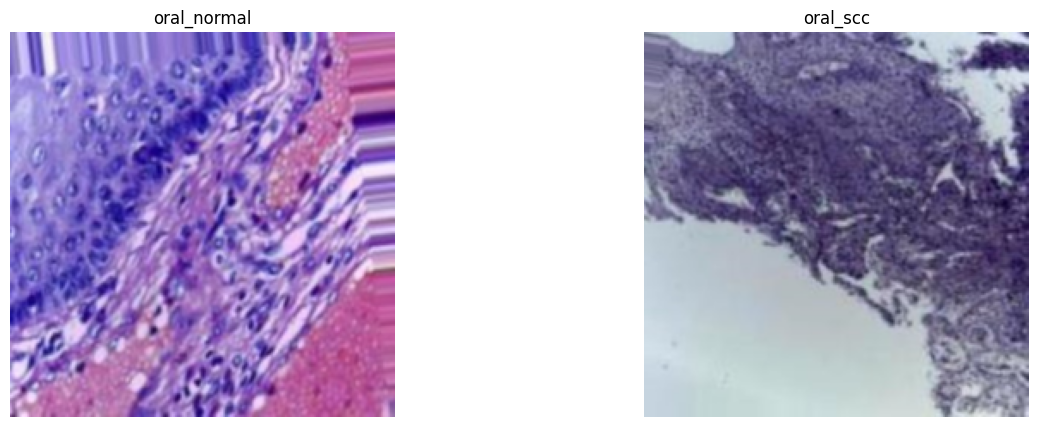

In [6]:
class_names = dataset.classes
num_classes = len(class_names)

fig, axs = plt.subplots(1, num_classes, figsize=(15, 5))

displayed_classes = {class_name: False for class_name in class_names}

for images, labels in train_loader:
    for img, label in zip(images, labels):
        class_name = class_names[label]
        if not displayed_classes[class_name]:
            img = img.permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5 
            axs[label].imshow(np.clip(img, 0, 1)) 
            axs[label].set_title(class_name)
            axs[label].axis('off')
            displayed_classes[class_name] = True  

        if all(displayed_classes.values()):
            break

    if all(displayed_classes.values()):
        break

plt.show()
